# Introduction to Pytorch, Keras and Shallow Networks

In this lab we will create our first neural network. It will be a shallow one, over a small dataset, so it is not a good example of a real-life problem where neural networks shine, but it will be a great way to understand the network architectures and what can we do with the model.

In this lab, and in general in future examples, we will closely follow the book "Deep Learning with Python" by Chollet. The library has copies of the book.

## Loading the data

We will import one of the data examples from Keras itself: Prices in Boston.

But first, what is Keras?

[Keras](https://keras.io/) is an abstraction layer to speed-up development of deep learning models. It works on top of lower-level APIs such as [Pytorch](https://pytorch.org/), [Jax](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html) or [Tensorflow](https://www.tensorflow.org/). Deep Learning requires a set of very sophisticated optimizers and computational calculations, so it can be tricky to program directly. Luckily for us, we can simply use Keras to call the more sophisticated programs that will do the heavy lifting for us.

Technically, Keras is a "front-end", while the calculation engine will be a "backend". Those backends (pytorch, jax, tensorflow) will actually call a backend of their own which will communicate with the machine itself.

We will continue using Google Colab's environment, so you don't need to do this. What we need to do is to change our execution environment to a GPU one. For that:

- Click Runtime
- Select "Change runtime type"
- In the menu, in the combo box below "Hardware Accelerator" select GPU.

Now we are ready to use Keras!

## Keras Sequential API

We will use Pytorch as our backend. Pytorch is, today, the most used academic backend. Corporate backends are a bit in the air, with tensorflow a legacy system, and jax/pytorch fighting for the rest. However, most new developments are in Pytorch, so it makes sense to use it.

To configure it, we must tell Keras to look for pytorch via an environmental variable. This must be done **before importing Keras**. We must also import the newest version of Keras to use the multibackend properties.

In [1]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.4 which is incompatible.


In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"

The easiest model that can be constructed in Keras is a sequential model. This is the typical neural network with one input layer, and one output layer, and a linear sequence of as many layers as we want in-between. A tutorial for the sequencial API can be found [here](https://keras.io/getting-started/sequential-model-guide/).

Let's load the packages.

In [3]:
import torch
import keras
import matplotlib.pyplot as plt

from keras import models
from keras import layers
from sklearn.preprocessing import StandardScaler
from keras.utils import plot_model
from IPython.display import Image
%matplotlib inline

In [4]:
print(keras.__version__)

3.0.4


Let's load the data.

In [5]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
print('Size of the training set: ', train_data.shape)
print('Size of the test set: ', test_data.shape)

Size of the training set:  (404, 13)
Size of the test set:  (102, 13)


This is a very small dataset, with only 404 cases for training, 102 for testing, 13 variables, and 1 target representing the median house price in Boston for the neighbourhood. The variables can be found [here](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html).

We have one problem: All variables are in different scales. The following code normalizes the data. Remember that, to avoid test set leak, you should normalize the data using the information from the train test and applying it to the test set. Scikit-Learn has the useful [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) function that you can use.

In [7]:
# Create the transformer.
scaler = StandardScaler()

# Train in the train set and change the original data
train_data = scaler.fit_transform(train_data)

# Apply to the test set
test_data = scaler.transform(test_data)

Now we can create our model. We want to build the following architecture:

![](https://drive.google.com/uc?export=view&id=1CfIe77tmoQrh4QEBFZtabYpiM3rdNOOs)

This example uses the optimizer SGD, the most basic optimizer. There are many optimizers, but as a rule of thumb, test  Adam first, and if it does not work, test SGD and RMSProp. **All of them solve the same backpropagation problem**, they are just tuned to certain data structures. A great comparison of different optimization algorithms can be found [here](http://ruder.io/optimizing-gradient-descent/index.html).

To construct the model, we create a "model" object using Keras API. This is simply a container which will hold the general structure of our model, and we will add layers to it. Let's import the layers and the models helper functions.

Now, let's build an empty sequential model. Let's name it "model" (yeah, original).

In [8]:
model = models.Sequential()

This is just an empty model, it does not have any layers! We also need to tell this first layer what input to expect, we do this with the "Input" layer. In this case, we are giving it a vector of size 13.

In [9]:
model.add(keras.Input(shape=(13,)))

Let's add the first hidden layer. For each model object that we have, the function "add" will append a layer stacking one on top of the other.

Remember, we want to add a fully-connected (Dense)layer, with 64 hidden neurons and ReLU activation function.

In [11]:
model.add(layers.Dense(64, # The number of neurons
                      activation = 'relu', # The type of activation
                      ))

Keras supports many activations. The list can be seen [here](https://keras.io/activations/). It also has many types of layers! The list [here](https://keras.io/layers/about-keras-layers/). Don't worry about this now, we will use many in the coming labs.

Let's add one more Dense layer.

In [10]:
model.add(layers.Dense(64, activation = 'relu'))

Note that now we didn't need to specify inputs and outputs, Keras will deduce them from the previous layer (thus the sequential structure!).

Now, let's add the final output layer. This is simply a Dense layer, of size 1 and ReLU activation. As this is a regression problem, we want outputs between $(0,\infty)$.

In [12]:
model.add(layers.Dense(1, activation = 'relu'))

With the model ready, the last step is to tell it how to train it. For this, we tell it to "compile it", and give it an optimizer. Note the error is the Minimum Square Error (MSE), which is used for regressions. We will see several more for different applications, but the list can be checked [here](https://keras.io/losses/).

In [13]:
opt = keras.optimizers.SGD(learning_rate=0.0001) # 10^-3, 10^-4, 10^-6
# opt = keras.optimizers.ADAM()

model.compile(optimizer = opt,                      # The optimizer just defined
              loss = keras.losses.MeanSquaredError()# The loss
              )

The optimizer has a learning rate parameter that needs to be set. For this lab we will ignore it and just use the default, but we will dig much deeper into this in the future.

We can take a look at the model structure by running the following command:

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ dense (Dense)                      │ (None, 64)                    │         896 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_1 (Dense)                    │ (None, 64)                    │       4,160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_2 (Dense)                    │ (None, 1)                     │          65 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 5,121 (20.00 KB)

 Trainable params: 5,121 (20.00 KB)

 Non-trainable params: 0 (0.00 B)

Or we can show it much more nicely in a picture.

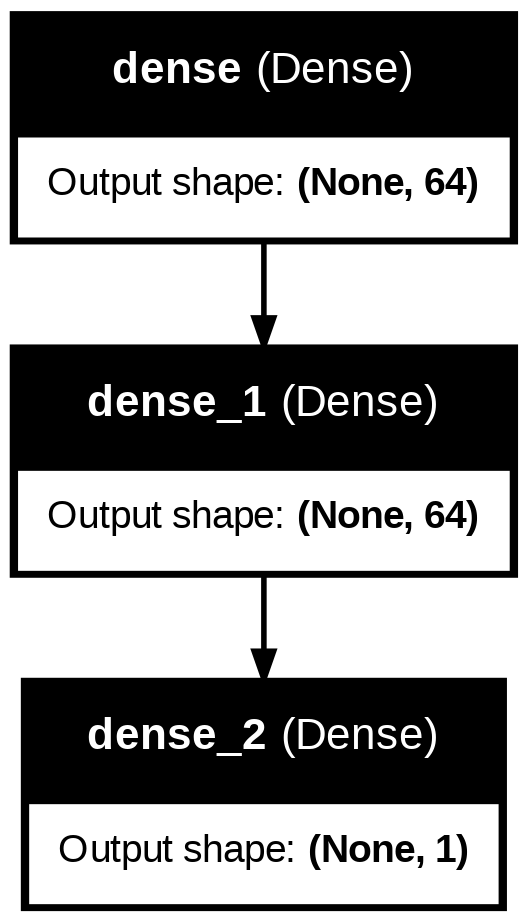

In [15]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

## Training and testing

Now we can simply train the model! It follows the same fitting structure of scikit-learn, with a 'fit' function we will use to tell the model the data it needs to train on.

In [18]:
history = model.fit(train_data, #X
                    train_targets, #Y
                    epochs = 100, # Rounds of training
                    batch_size=128, # Size of elements
                    validation_split= 0.25) # Validation split

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 30.2380 - val_loss: 54.0985
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 31.5292 - val_loss: 53.6069
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 33.1914 - val_loss: 53.1808
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 33.1047 - val_loss: 52.6614
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 32.8050 - val_loss: 52.1145
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 33.9853 - val_loss: 51.6208
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 30.0375 - val_loss: 51.1888
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 28.0833 - val_loss: 50.8376
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 32.8701 - val_loss: 50.4924
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 31.5409 - val_loss: 50.1012
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 31.9897 - val_loss: 49.7334
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step -

Done! Let's examine the command in detail:

- The first two arguments give us the traning data and the training targets. These should always be Numpy arrays, or other compatible tensors.

- epochs: Neural networks are trained using batches of data, which are shuffled and then fed back to the network. Each full pass of the data is called an "Epoch". We will use the number of epochs to control overfitting with the validation sample.

- batch_size: For big data models, it is not possible to train the model with all data at once, as we could be done here. The reason for that is that the model may not fit in memory, or that we need to stream data from an online source. The traditional way is to train in "batches". Recommended batches size are between 32 (for big applications) to 256 (for small problems). In general, we want to keep it small to create "diversity" in the data.

- validation_split: As this model is *very* prone to overfitting, we need to control it somehow. The validation data will help us with this. We will stop training as soon as we start worsening the validation sample. That will be the cut for the epochs in later iterations. We use a 25% split for validation cases. Another alternative is to provide a new set of data to use as validation data, we would use  "validation_data = (val_train, val_target)" instead of this split commmand.


The output we currently have gives us a training loss and a validation loss. This is measured in MSE. But, should we keep training? Are we making any gains?

The following code allows us to visualize the regression metrics.

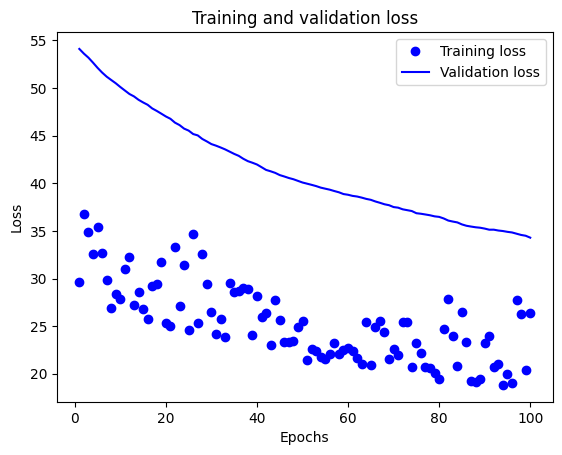

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

A good rule of thumb to analyse these results is this image.

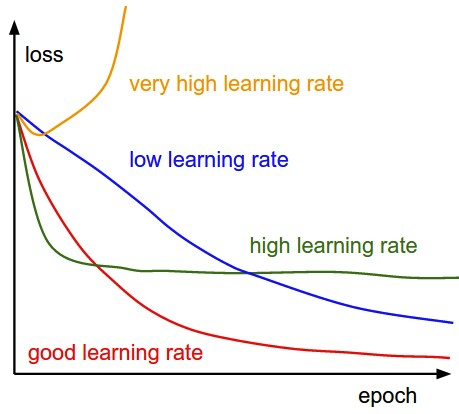

Is it worth it to retrain? If you run the "fit" command again, Keras will optimize *over the parameters already found*, so we would actually be improving the result over the training set (but potentially worsening it over the validation set!). The goal is to find a number of epochs that gives us the best result.

In our case: the validation loss and the training loss are still going down! We can continue training. Let's give it 100 more epochs.

In [20]:
history = model.fit(train_data, train_targets, epochs = 100, batch_size=128,
                    validation_split= 0.25)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 22.7854 - val_loss: 34.1200
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 20.0213 - val_loss: 34.0664
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 19.4031 - val_loss: 33.9410
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 21.2839 - val_loss: 33.8804
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 19.2165 - val_loss: 33.7575
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 22.1477 - val_loss: 33.6691
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 20.1897 - val_loss: 33.5507
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 21.4990 - val_loss: 33.4751
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 19.4014 - val_loss: 33.4269
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 21.0588 - val_loss: 33.2769
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 20.9278 - val_loss: 33.1641
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step -

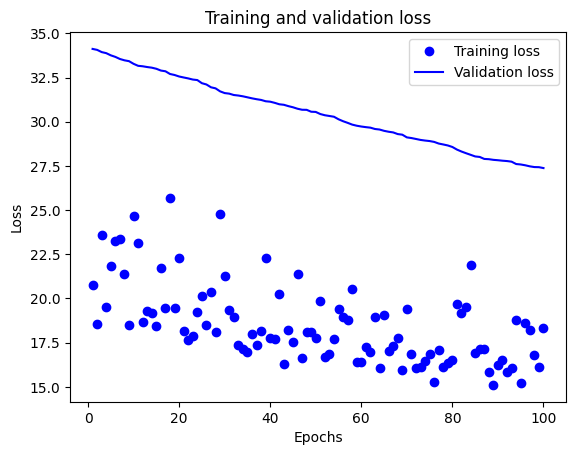

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

It is still going down! As a self-study exercise, keep training the model until you see an increase in validation loss. You should train until this happen, so keep an eye in your models!

And how did we do in the test set? The "evaluate" internal function allows us to validate on new data.

In [22]:
model.evaluate(test_data, test_targets)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 24.9381


32.97357940673828

We can use this number to compare against other models. Or take the square root to get an idea of the average error to be incurred, and then decide.

Alternatively, if we want to get the value of the predictions, we can use the following command, which returns a prediction over the test data.

In [23]:
model.predict(test_data)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([[11.246294],
       [16.367764],
       [20.637585],
       [26.943186],
       [25.108763],
       [15.512953],
       [26.463938],
       [21.787088],
       [19.385996],
       [17.792059],
       [12.177938],
       [17.68816 ],
       [18.408403],
       [42.096043],
       [15.245924],
       [18.257463],
       [25.096209],
       [21.24176 ],
       [16.806656],
       [21.260935],
       [13.481312],
       [12.051901],
       [18.02415 ],
       [12.428837],
       [23.420298],
       [18.41053 ],
       [29.500128],
       [31.728626],
       [12.290985],
       [20.500235],
       [18.323187],
       [12.18045 ],
       [32.340004],
       [23.263811],
       [15.100468],
       [12.813482],
       [14.917295],
       [12.618349],
       [20.969198],
       [28.15893 ],
       [31.167122],
       [28.883684],
       [17.258749],
       [35.363583],
       [33.388046],
       [24.351252],
       [25.503508],
       [14.662695],
       [21.152128],
       [21.561312],


And that's it! We have our first shallow neural network trained. In future labs we will be adding complexity to this by for example using more complex text-based embeddings, images, etc.

# Self Study

Go through this example again, but now following Chapter 3.6 of Chollet's book. There you'll learn how to use Cross-Validation to model this example. Modify the activations and the size of the network. Try, for example:

- Using SeLU instead of ReLU
- Adding one more hidden layer
- Changing the number of neurons from 64 to 128
- ...etc

Can you reach a better predictive capability over the test set? Creating an architecture is an art, so be creative and do your best effort!